In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
from import_casa import casa
from casa import caprice
from icecream import ic

In [3]:
with open("../../../data/caprice/caprice_seq_data_20210430.pkl", "rb") as fin:
    data = pickle.load(fin)

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path = "../../../data/caprice/seq-model-ep9"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [5]:
from matplotlib import font_manager

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"
# plt.rcParams["font.family"] = "Heiti TC"

In [7]:
import shap

In [32]:
from transformers import pipeline
caprice_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True)

In [33]:
explainer = shap.Explainer(caprice_pipeline, algorithm="partition")

In [34]:
_masker = explainer.masker

In [35]:
import torch
from DistilTag import DistilTag
tagger = DistilTag()

In [36]:
tagger.tag("我才不要去辦吃到飽")

[[('我', 'Nh'),
  ('才', 'Da'),
  ('不要', 'D'),
  ('去', 'D'),
  ('辦', 'VC'),
  ('吃', 'VC'),
  ('到', 'P'),
  ('飽', 'VH')]]

## Try hierarchical shapley

In [37]:
from types import MethodType
from functools import partial
from scipy.cluster.hierarchy import to_tree, dendrogram
txt = "他貴到一個爆炸"

clustering_wrapper = partial(caprice.custom_clustering, pat="", tagger_inst=tagger)
explainer.masker.clustering = MethodType(clustering_wrapper, explainer.masker)
shap_values = explainer([txt], fixed_context=0)

In [38]:
probs = [x["score"] for x in caprice_pipeline(txt)[0]]
max_label = np.argmax(probs)
# max_label = 1

In [39]:
Z = shap_values.clustering[0]

In [40]:
root, clust_nodes = to_tree(Z, rd=True)

In [41]:
Z

array([[ 7.        ,  6.        ,  0.17089015,  2.        ],
       [ 3.        ,  2.        ,  0.3227866 ,  2.        ],
       [ 5.        ,  4.        ,  0.36983135,  2.        ],
       [11.        , 10.        ,  0.4077597 ,  4.        ],
       [ 9.        , 12.        ,  0.63041621,  6.        ],
       [ 1.        ,  0.        ,  0.64684439,  2.        ],
       [13.        , 14.        ,  0.75969934,  8.        ],
       [ 8.        , 15.        ,  1.        ,  9.        ]])

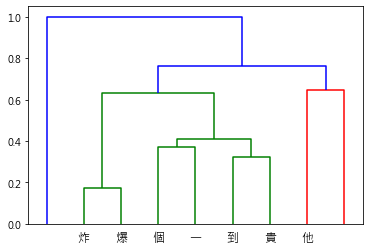

In [42]:
ex_tokens = _masker._segments_s
dendrogram(shap_values.clustering[0], labels=ex_tokens);

In [43]:
# check dimensions
ic(Z.shape, len(ex_tokens))
ic(len(clust_nodes), shap_values.hierarchical_values[0].shape)

ic| Z.shape: (8, 4), len(ex_tokens): 9
ic| len(clust_nodes): 17
    shap_values.hierarchical_values[0].shape: (17, 3)


(17, (17, 3))

In [44]:
proc_vals = caprice.process_shap_values(shap_values[0, :, max_label])

In [45]:
proc_vals

{'tokens': array(['', '炸', '爆', '個一到貴', '他', ''], dtype='<U4'),
 'values': array([-3.03609176e-07,  2.39403802e-01, -1.37267721e-01,  5.21287731e+00,
         1.15447771e-01, -1.01839585e-01]),
 'group_sizes': array([1, 1, 1, 4, 1, 1]),
 'upper_values': array([-1.01839801e-01, -1.01839801e-01,  1.03923267e+00,  1.03923267e+00,
         4.06055705e-01,  4.06055705e-01, -1.80733609e-01, -1.80733609e-01,
        -3.03609176e-07, -7.38471424e-02,  1.82049244e+00,  1.82049244e+00,
        -7.38471424e-02, -2.03679152e-01, -2.03679152e-01, -3.03609176e-07,
         0.00000000e+00]),
 'lower_values': array([2.16839859e-07, 2.17287573e-01, 7.73098956e-01, 4.23637440e-01,
        5.37609921e-01, 5.87954245e-01, 4.34658881e-02, 4.20137411e-01,
        0.00000000e+00, 1.75983223e-01, 1.45470929e+00, 1.17183134e-01,
        5.28672445e+00, 5.51869254e+00, 2.17287339e-01, 5.32862188e+00,
        5.32862127e+00]),
 'group_values': array([-1.01839585e-01,  1.15447771e-01,  1.81233162e+00,  1.46287011

In [46]:
group_values = proc_vals["group_values"]
for node_i, node_x in enumerate(clust_nodes):
    leaf_ids = node_x.pre_order(lambda x: x.id)
    print("% .2e" % group_values[node_i], "".join(ex_tokens[x] for x in sorted(leaf_ids)))

-1.02e-01 
 1.15e-01 他
 1.81e+00 貴
 1.46e+00 到
 9.44e-01 一
 9.94e-01 個
-1.37e-01 爆
 2.39e-01 炸
-3.04e-07 
 1.02e-01 爆炸
 3.28e+00 貴到
 1.94e+00 一個
 5.21e+00 貴到一個
 5.32e+00 貴到一個爆炸
 1.36e-02 他
 5.33e+00 他貴到一個爆炸
 5.33e+00 他貴到一個爆炸


In [47]:
shap.plots.text(shap_values[0, :, max_label])